In [84]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [85]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [86]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [87]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [88]:
tf.keras.backend.clear_session()

In [89]:
subject = 'Minas Gerais - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [90]:
data = pd.read_csv('2003_mo_model_input_MG.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Minas Gerais- custo m2 (R$),Minas Gerais - IDH,Minas Gerais - Consumo de Cimento (t),Minas Gerais - Depósito Poupança (R$),Minas Gerais - IDH Educacao,Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Per Capita,Minas Gerais - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade
0,2003-1,10943.259600,0.756537,247.134,2.263741e+07,0.698929,0.334536,0.759345,1.881651,889.396645,1304.196449,18.796583,16.168039,85.634952,0.300000,648.891160,8.242462,2.937752e+08,1.725077e+07,14.096054,2.759117e+08,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.826175
1,2003-2,11044.202677,0.756708,305.708,2.272827e+07,0.699250,0.335670,0.759119,1.872777,889.450610,1289.394416,18.293640,15.115445,83.129710,0.300000,652.396314,8.236470,2.941480e+08,1.726959e+07,14.102603,2.760648e+08,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.826617
2,2003-3,11138.440825,0.756879,284.168,2.281913e+07,0.699571,0.336553,0.758894,1.638997,889.584406,1285.306737,18.099369,14.148246,79.655520,0.300000,655.911573,8.230479,2.945208e+08,1.728841e+07,14.109152,2.762178e+08,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.827060
3,2003-4,11231.690825,0.757050,286.594,2.290999e+07,0.699892,0.336531,0.758669,1.339260,890.048010,1258.400433,17.617245,13.127518,77.295209,0.380914,656.746430,8.224488,2.948935e+08,1.730723e+07,14.115701,2.763709e+08,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.827502
4,2003-5,11322.829101,0.757222,312.455,2.300085e+07,0.700213,0.336406,0.758443,1.204123,890.232394,1261.365893,17.005052,12.074203,74.991327,0.574731,660.114672,8.218497,2.952663e+08,1.732605e+07,14.122250,2.765239e+08,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.827945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,38004.550289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,37962.793190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,37913.793566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,37853.865772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


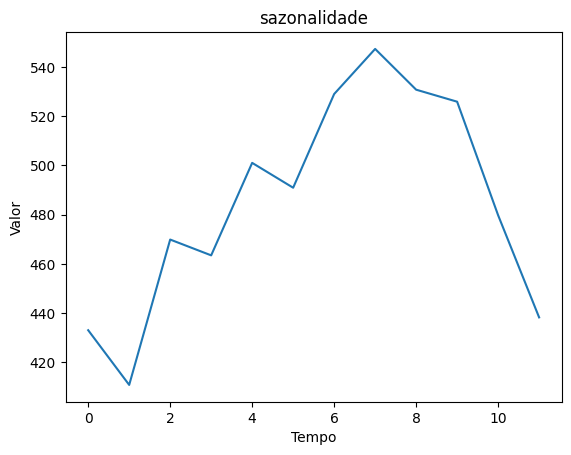

,sazonalidade
sazonalidade,
0,433.074877
1,410.853921
2,469.902617
3,463.483342
4,501.051317
5,490.953269
6,529.013977
7,547.337142
8,530.783270


In [91]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [92]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Minas Gerais- custo m2 (R$),Minas Gerais - IDH,Minas Gerais - Depósito Poupança (R$),Minas Gerais - IDH Educacao,Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Per Capita,Minas Gerais - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade,sazonalidade,Minas Gerais - Consumo de Cimento (t)
0,2003-1,10943.259600,0.756537,2.263741e+07,0.698929,0.334536,0.759345,1.881651,889.396645,1304.196449,18.796583,16.168039,85.634952,0.300000,648.891160,8.242462,2.937752e+08,1.725077e+07,14.096054,2.759117e+08,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.826175,433.074877,247.134
1,2003-2,11044.202677,0.756708,2.272827e+07,0.699250,0.335670,0.759119,1.872777,889.450610,1289.394416,18.293640,15.115445,83.129710,0.300000,652.396314,8.236470,2.941480e+08,1.726959e+07,14.102603,2.760648e+08,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.826617,410.853921,305.708
2,2003-3,11138.440825,0.756879,2.281913e+07,0.699571,0.336553,0.758894,1.638997,889.584406,1285.306737,18.099369,14.148246,79.655520,0.300000,655.911573,8.230479,2.945208e+08,1.728841e+07,14.109152,2.762178e+08,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.827060,469.902617,284.168
3,2003-4,11231.690825,0.757050,2.290999e+07,0.699892,0.336531,0.758669,1.339260,890.048010,1258.400433,17.617245,13.127518,77.295209,0.380914,656.746430,8.224488,2.948935e+08,1.730723e+07,14.115701,2.763709e+08,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.827502,463.483342,286.594
4,2003-5,11322.829101,0.757222,2.300085e+07,0.700213,0.336406,0.758443,1.204123,890.232394,1261.365893,17.005052,12.074203,74.991327,0.574731,660.114672,8.218497,2.952663e+08,1.732605e+07,14.122250,2.765239e+08,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.827945,501.051317,312.455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,38004.550289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,501.051317,NaN
245,2023-6,37962.793190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,490.953269,NaN
246,2023-7,37913.793566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,529.013977,NaN
247,2023-8,37853.865772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,547.337142,NaN


In [93]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      268.591
1      246.372
2      292.439
3      310.034
4      322.741
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: Minas Gerais - Consumo de Cimento (t), Length: 249, dtype: float64

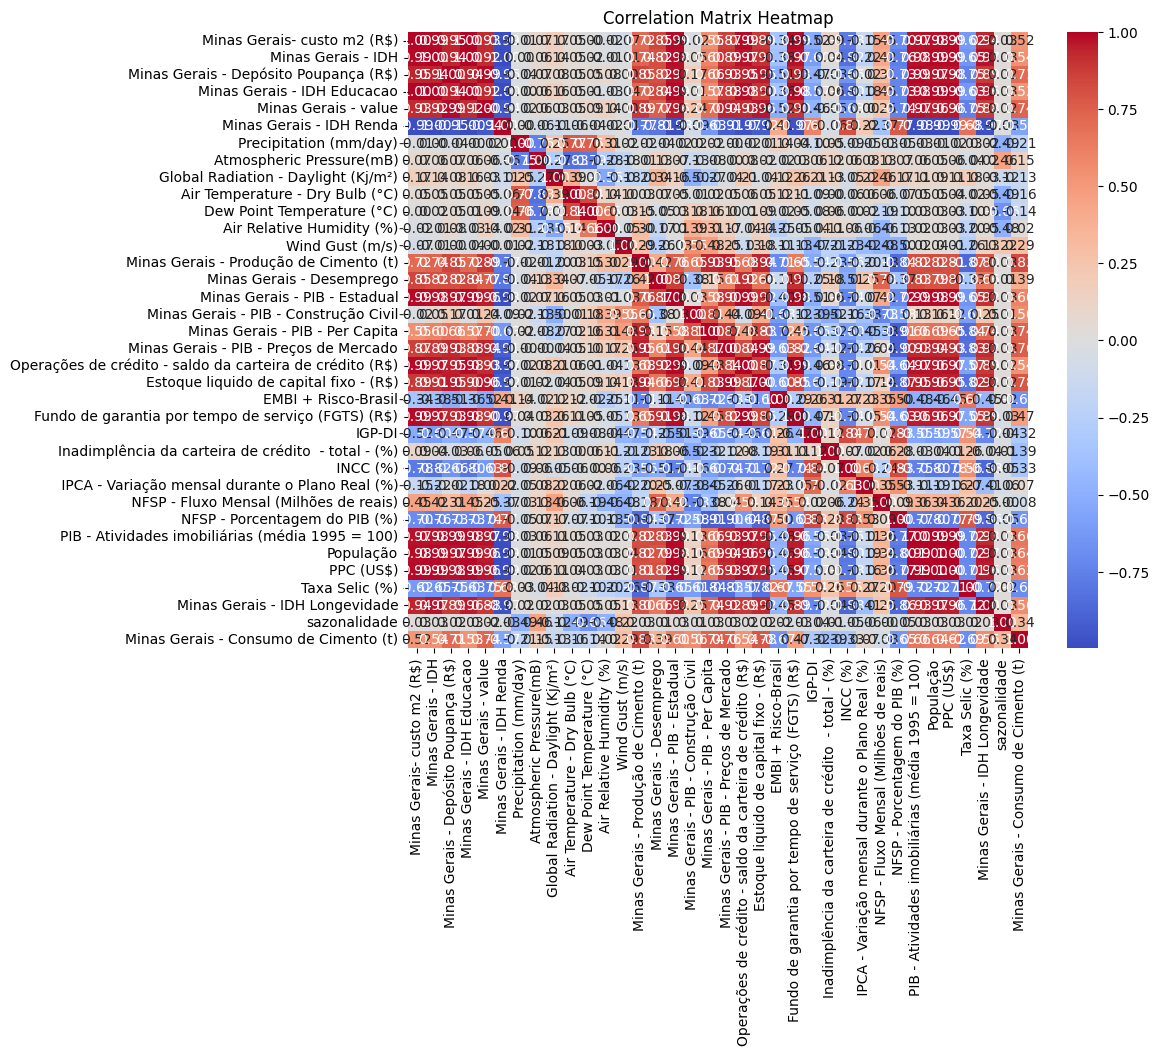

In [94]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [95]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [96]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Minas Gerais- custo m2 (R$),1.340237e+06
1,Minas Gerais - IDH,6.240776e+09
2,Minas Gerais - Depósito Poupança (R$),2.214542e+04
3,Minas Gerais - IDH Educacao,7.661255e+09
4,Minas Gerais - value,1.907585e+05
5,Minas Gerais - IDH Renda,1.045961e+05
6,Precipitation (mm/day),9.447859e+01
7,Atmospheric Pressure(mB),1.453248e+07
8,Global Radiation - Daylight (Kj/m²),2.869547e+03
9,Air Temperature - Dry Bulb (°C),3.927995e+05


In [97]:
data = remove_high_vif_columns(safe_data, 10000000)
data

Num columns removed: 6


,Minas Gerais- custo m2 (R$),Minas Gerais - Depósito Poupança (R$),Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade,sazonalidade
0,10943.259600,2.263741e+07,0.334536,0.759345,1.881651,889.396645,1304.196449,18.796583,16.168039,85.634952,0.300000,648.891160,8.242462,2.937752e+08,1.725077e+07,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,0.826175,433.074877
1,11044.202677,2.272827e+07,0.335670,0.759119,1.872777,889.450610,1289.394416,18.293640,15.115445,83.129710,0.300000,652.396314,8.236470,2.941480e+08,1.726959e+07,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,0.826617,410.853921
2,11138.440825,2.281913e+07,0.336553,0.758894,1.638997,889.584406,1285.306737,18.099369,14.148246,79.655520,0.300000,655.911573,8.230479,2.945208e+08,1.728841e+07,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,0.827060,469.902617
3,11231.690825,2.290999e+07,0.336531,0.758669,1.339260,890.048010,1258.400433,17.617245,13.127518,77.295209,0.380914,656.746430,8.224488,2.948935e+08,1.730723e+07,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,0.827502,463.483342
4,11322.829101,2.300085e+07,0.336406,0.758443,1.204123,890.232394,1261.365893,17.005052,12.074203,74.991327,0.574731,660.114672,8.218497,2.952663e+08,1.732605e+07,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,0.827945,501.051317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,25160.770041,4.736807e+07,0.504771,0.730032,1.224714,890.086257,1343.108259,17.456174,11.820392,72.581273,2.151380,1076.243174,9.675295,3.479272e+08,1.763275e+07,3.068648e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,416.859692,0.583985,0.860787,547.337142
176,25258.852522,4.754273e+07,0.504929,0.730068,1.554792,889.302924,1368.506994,18.199447,12.610909,72.898563,2.139269,1080.201322,9.659046,3.479130e+08,1.763790e+07,3.070265e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,417.748887,0.753312,0.860685,530.783270
177,25357.964895,4.771740e+07,0.505091,0.730104,1.851394,888.264836,1336.305494,18.884799,13.694447,74.672635,2.096169,1085.215611,9.642798,3.478988e+08,1.764305e+07,3.078615e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,418.601189,0.882343,0.860583,525.899532
178,25458.007911,4.789206e+07,0.505254,0.730140,1.814231,887.617907,1302.620290,19.177880,14.503357,76.779838,2.009972,1089.574366,9.626549,3.478847e+08,1.764820e+07,3.083099e+06,263.741041,1.073635e+07,0.491301,3.476080,0.370057,0.352728,-6243.191421,2.263185,198.211712,419.430070,1.004174,0.860480,479.784286


In [98]:
input_data = data.iloc[:split_index + 1,1:]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Minas Gerais - Depósito Poupança (R$),Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade,sazonalidade
0,-1.601330,-1.456859,1.897418,0.618363,0.398574,0.689935,0.180549,1.488531,2.416841,-4.452741,-2.068725,-0.639429,-1.693066,-2.005569,-1.310937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-1.798021,2.127040,-2.405697,-1.242709
1,-1.591362,-1.441424,1.871484,0.596416,0.447504,0.525451,-0.284979,0.735728,1.681692,-4.452741,-2.048226,-0.646115,-1.672376,-1.955577,-1.310358,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.785942,1.562580,-2.357209,-1.774155
2,-1.581395,-1.429415,1.845550,0.018227,0.568815,0.480028,-0.464797,0.043998,0.662211,-4.452741,-2.027668,-0.652801,-1.651685,-1.905585,-1.310320,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.773475,3.033368,-2.308720,-0.361921
3,-1.571428,-1.429714,1.819615,-0.723087,0.989159,0.181038,-0.911054,-0.686015,-0.030409,-4.270289,-2.022786,-0.659487,-1.630994,-1.855593,-1.309876,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.760719,1.229384,-2.260232,-0.515447
4,-1.561460,-1.431421,1.793681,-1.057311,1.156337,0.213991,-1.477705,-1.439333,-0.706470,-3.833255,-2.003087,-0.666173,-1.610304,-1.805601,-1.308476,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.748299,2.036088,-2.211743,0.383044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.111551,0.859531,-1.476551,-1.006385,1.023836,1.122332,-1.060143,-1.620856,-1.413686,-0.278096,0.430539,0.959580,1.312578,-0.990856,1.351069,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.421090,-1.472938,1.386892,1.490036
176,1.130711,0.861677,-1.472384,-0.190031,0.313598,1.404569,-0.372164,-1.055487,-1.320579,-0.305406,0.453687,0.941446,1.311792,-0.977176,1.352673,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.432650,-0.879688,1.375688,1.094127
177,1.149871,0.863883,-1.468217,0.543531,-0.627622,1.046738,0.262202,-0.280553,-0.799988,-0.402591,0.483012,0.923313,1.311005,-0.963496,1.360954,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.443731,-0.427616,1.364484,0.977325
178,1.169032,0.866099,-1.464051,0.451618,-1.214184,0.672420,0.533480,0.297970,-0.181641,-0.596956,0.508503,0.905180,1.310219,-0.949815,1.365401,-0.285262,1.756179,-0.359568,0.626702,-1.942040,-1.597335,0.244264,-0.555524,1.330436,1.454507,-0.000772,1.353280,-0.125587


In [99]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Minas Gerais - Depósito Poupança (R$),Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade,sazonalidade
0,-1.601330,-1.456859,1.897418,0.618363,0.398574,0.689935,0.180549,1.488531,2.416841,-4.452741,-2.068725,-0.639429,-1.693066,-2.005569,-1.310937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-1.798021,2.127040,-2.405697,-1.242709
1,-1.591362,-1.441424,1.871484,0.596416,0.447504,0.525451,-0.284979,0.735728,1.681692,-4.452741,-2.048226,-0.646115,-1.672376,-1.955577,-1.310358,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.785942,1.562580,-2.357209,-1.774155
2,-1.581395,-1.429415,1.845550,0.018227,0.568815,0.480028,-0.464797,0.043998,0.662211,-4.452741,-2.027668,-0.652801,-1.651685,-1.905585,-1.310320,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.773475,3.033368,-2.308720,-0.361921
3,-1.571428,-1.429714,1.819615,-0.723087,0.989159,0.181038,-0.911054,-0.686015,-0.030409,-4.270289,-2.022786,-0.659487,-1.630994,-1.855593,-1.309876,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.760719,1.229384,-2.260232,-0.515447
4,-1.561460,-1.431421,1.793681,-1.057311,1.156337,0.213991,-1.477705,-1.439333,-0.706470,-3.833255,-2.003087,-0.666173,-1.610304,-1.805601,-1.308476,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.748299,2.036088,-2.211743,0.383044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.892618,0.851510,-1.480851,0.061459,0.336784,0.571458,-0.566938,-0.920247,-0.867347,-0.210619,0.078902,1.299946,1.291357,-1.048685,1.407354,0.731931,1.338281,-1.087000,1.252487,-1.491033,-0.960452,1.465326,-0.676734,1.091879,1.261902,0.499090,1.501454,1.490036
164,0.909581,0.849183,-1.485824,0.257617,-0.246375,0.760923,-0.052474,-0.379471,-0.600832,-0.116115,0.092192,1.257259,1.296701,-1.056272,1.402136,0.583095,1.318191,-0.904679,1.414483,-1.525186,-1.007966,1.351131,-0.668750,1.100438,1.276272,0.323875,1.494228,1.094127
165,0.926543,0.850353,-1.490797,0.044540,-0.761248,0.957276,0.517064,0.164641,-0.434329,-0.256393,0.105936,1.214572,1.302046,-1.063859,1.398719,0.433167,1.483470,-0.900134,1.498244,-1.546744,-0.976556,1.143146,-0.657609,1.108997,1.290351,0.198030,1.487001,0.977325
166,0.943505,0.849346,-1.495770,1.033073,-0.980432,1.386067,0.931995,0.561414,-0.319696,-0.395526,0.109740,1.171885,1.307391,-1.071446,1.393142,0.297965,1.703486,-1.136836,1.476356,-1.586381,-1.146834,1.542609,-0.647588,1.117113,1.304501,0.502803,1.479774,-0.125587


In [100]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      268.591
1      246.372
2      292.439
3      310.034
4      322.741
        ...   
163    537.851
164    526.265
165    559.293
166    466.646
167    416.049
Name: Minas Gerais - Consumo de Cimento (t), Length: 168, dtype: float64

In [101]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [102]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 28)

In [103]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Minas Gerais - Depósito Poupança (R$),Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade,sazonalidade
132,1.367442,1.149636,-0.721306,0.632958,-0.741525,2.460061,1.209678,0.535477,-0.773702,-0.498971,0.782502,1.303743,0.997317,-0.068844,0.992500,-0.548487,1.079517,0.174628,-1.262693,-0.066954,1.530065,0.817451,-0.366715,1.072212,0.878252,-0.590376,0.405042,-1.242709
133,1.338585,1.144758,-0.718434,-0.122683,-0.624896,1.698236,0.709320,0.290421,-0.565516,-0.526796,0.755806,1.335770,1.008801,-0.119873,1.013803,-0.501591,0.954387,0.240832,-1.257770,-0.130652,1.649361,1.130195,-0.350285,1.078438,0.887574,-0.476859,0.397300,-1.774155
134,1.309728,1.144999,-0.715562,-0.389461,-0.182036,0.736319,0.063521,0.015977,-0.198215,-0.668752,0.727264,1.367796,1.020284,-0.170901,1.036490,-0.487442,0.917313,0.176857,-1.179613,-0.079602,1.622916,1.160498,-0.335122,1.084663,0.896990,-0.089952,0.389559,-0.361921
135,1.280872,1.142199,-0.712690,-0.759489,0.562392,-0.195887,-0.743945,-0.553972,-0.125575,-0.704048,0.697959,1.399823,1.031767,-0.221929,1.059637,-0.477666,0.905701,-0.005233,-1.150081,-0.034473,1.581460,1.131990,-0.321950,1.090889,0.906245,-0.814200,0.381817,-0.515447
136,1.252015,1.139083,-0.709818,-0.553414,1.117459,-0.381717,-1.309622,-1.287283,-0.599868,-0.679128,0.668335,1.431850,1.043251,-0.272957,1.080606,-0.476309,0.917044,0.097576,-1.102711,-0.177535,1.638292,1.384387,-0.302995,1.095273,0.915208,-0.917944,0.374076,0.383044
137,1.223158,1.123974,-0.706946,-0.660320,1.407159,-0.061854,-1.384372,-1.638581,-1.082862,-0.569665,0.638304,1.463876,1.054734,-0.323986,1.101264,-0.468224,0.926784,0.431487,-1.100246,-0.208868,1.643773,1.375487,-0.290554,1.099656,0.924126,-0.708692,0.366335,0.141535
138,1.194302,1.099339,-0.704074,-0.322050,1.427464,0.594713,-1.259487,-1.949589,-1.703770,-0.252158,0.608023,1.495903,1.066217,-0.375014,1.123860,-0.449308,0.951808,0.482414,-1.083821,-0.245300,1.704584,1.438928,-0.281926,1.104040,0.932114,-0.496126,0.358593,1.051811
139,1.165445,1.101613,-0.701202,0.490859,0.738686,1.383883,-0.773468,-1.772515,-1.994019,-0.063536,0.577264,1.527929,1.077701,-0.426042,1.150086,-0.429479,0.970898,0.657043,-1.080043,-0.333490,1.841703,1.569590,-0.275931,1.104434,0.939863,-0.251065,0.350852,1.490036
140,1.136588,1.063990,-0.698329,0.182424,0.133130,1.906224,-0.093239,-1.226810,-1.980453,-0.031707,0.546370,1.559956,1.089184,-0.477071,1.179474,-0.410867,0.982071,0.678386,-1.159959,-0.296846,1.837218,1.584058,-0.271466,1.104827,0.947944,-0.593206,0.343110,1.094127
141,1.107732,1.035799,-0.695457,0.757864,-0.206972,2.387796,0.617757,-0.726530,-2.027037,-0.150462,0.515565,1.591983,1.100667,-0.528099,1.214576,-0.384008,1.141593,0.727143,-1.291433,-0.292462,1.797860,1.166380,-0.273241,1.105221,0.956229,-0.100794,0.335369,0.977325


In [104]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 28)

In [105]:
def lstm_model(train_input, train_target, 
               first_layer_n_cells, 
               second_layer_n_cells,
               third_layer_n_cells,
               want_verbose=1, seed=0):
    
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=500,
        verbose=want_verbose,
        restore_best_weights=True,
        start_from_epoch=500
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.LSTM(
        first_layer_n_cells,
        activation='tanh',
        return_sequences=True,
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        input_shape=(train_input.shape[1], train_input.shape[2])
    ))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(
        second_layer_n_cells,
        activation='tanh',
        return_sequences=(third_layer_n_cells > 0),
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    ))
        
    if third_layer_n_cells > 0:
        model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.LSTM(
            third_layer_n_cells,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.l2(0.01)
        ))
        
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')    
    history = model.fit(
        train_input,
        train_target,
        epochs=10000,
        validation_split=0.07,
        callbacks=[early_stopping],
        verbose=want_verbose
    )
    
    return model, history

In [106]:
def get_a_good_seed(train_input, train_target, first_layer_n_cells, second_layer_n_cells, third_layer_n_cells):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(2)]
    list_loss = []
    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, 
                                    first_layer_n_cells, second_layer_n_cells, third_layer_n_cells,
                                    want_verbose=0, seed=seed)
        
        current_loss = min(history.history['val_loss'][500:])
        list_loss.append(current_loss)
        print(f"val_loss: {current_loss}")
        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed, np.mean(list_loss)

    return winner_seed, np.mean(sorted(list_loss))

In [107]:
# Tuning range
first_layer_cells_list = [36, 72, 144]
second_layer_cells_list = [36, 72, 144]
third_layer_cells_list = [0, 36, 72, 144]

In [108]:
def hyperparameter_tuning(train_input, train_target, 
                          first_layer_cells_list, second_layer_cells_list, third_layer_cells_list):
    
    best_loss = float('inf')
    best_combination = None
    
    for first_cells in first_layer_cells_list:
        for second_cells in second_layer_cells_list:
            for third_cells in third_layer_cells_list:
                if not third_cells > second_cells:
                    print(f"_________________________________________________________________________________________")
                    print(" ")
                    print(f" Testing [{first_cells}, {second_cells}, {third_cells}]")
                    print(f"_________________________________________________________________________________________")

                    winner_seed, mean_loss = get_a_good_seed(train_input, train_target, 
                                                                first_cells, second_cells, third_cells)
                    print(" ")
                    print(f"first_layer_n_cells: {first_cells}")
                    print(f"second_layer_n_cells: {second_cells}")
                    print(f"third_layer_n_cells: {third_cells}")
                    if mean_loss < best_loss:
                        best_loss = mean_loss
                        best_combination = [first_cells, second_cells, third_cells, winner_seed]
                        print(f"best_loss: {best_loss}")
                        print(f"winner_seed: {winner_seed}")
                    print(" ")
            
    return best_combination

In [109]:
best_combination = hyperparameter_tuning(reshaped_train, 
                                         reshaped_target, 
                                         first_layer_cells_list, 
                                         second_layer_cells_list, 
                                         third_layer_cells_list)
best_combination

_________________________________________________________________________________________
 
 Testing [36, 36, 0]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 6254.94384765625
winner_seed: 4247749749


Step: 1 ___________________________________________
val_loss: 5793.68212890625
winner_seed: 233180071
 
first_layer_n_cells: 36
second_layer_n_cells: 36
third_layer_n_cells: 0
best_loss: 6024.31298828125
winner_seed: 233180071
 
_________________________________________________________________________________________
 
 Testing [36, 36, 36]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 5531.51513671875
winner_seed: 308594082


Step: 1 ___________________________________________
val_loss: 5798.54736328125
 
first_layer_n_cells: 36
second_layer_n_cells: 36
third_layer_n_cells: 

val_loss: 5799.794921875
winner_seed: 313929791
 
first_layer_n_cells: 72
second_layer_n_cells: 144
third_layer_n_cells: 72
 
_________________________________________________________________________________________
 
 Testing [72, 144, 144]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 5836.99853515625
winner_seed: 819165982


Step: 1 ___________________________________________
val_loss: 2864.9189453125
winner_seed: 2810175323
 
first_layer_n_cells: 72
second_layer_n_cells: 144
third_layer_n_cells: 144
 
_________________________________________________________________________________________
 
 Testing [144, 36, 0]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 3642.034423828125
winner_seed: 1160583072


Step: 1 ___________________________________________
val_loss: 5833.15

[144, 144, 0, 1039767037]

In [110]:
best_combination

[144, 144, 0, 1039767037]

In [111]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target,
                                    best_combination[0], best_combination[1], best_combination[2],
                                    want_verbose=1, 
                                    seed=best_combination[3])

Epoch 1/10000
4/4 [==============================] - 2s 132ms/step - loss: 292626.8750 - val_loss: 224537.0469
Epoch 2/10000
4/4 [==============================] - 0s 11ms/step - loss: 282347.6250 - val_loss: 218531.0469
Epoch 3/10000
4/4 [==============================] - 0s 10ms/step - loss: 278164.5000 - val_loss: 215884.9062
Epoch 4/10000
4/4 [==============================] - 0s 10ms/step - loss: 275192.4062 - val_loss: 213253.4531
Epoch 5/10000
4/4 [==============================] - 0s 9ms/step - loss: 272258.7812 - val_loss: 210636.1562
Epoch 6/10000
4/4 [==============================] - 0s 11ms/step - loss: 269285.0312 - val_loss: 208030.7500
Epoch 7/10000
4/4 [==============================] - 0s 10ms/step - loss: 266357.6875 - val_loss: 205439.2344
Epoch 8/10000
4/4 [==============================] - 0s 14ms/step - loss: 263422.6250 - val_loss: 202875.6406
Epoch 9/10000
4/4 [==============================] - 0s 11ms/step - loss: 260515.5781 - val_loss: 200341.6875
Epoch 10/1

Epoch 75/10000
4/4 [==============================] - 0s 14ms/step - loss: 121863.6172 - val_loss: 81916.2109
Epoch 76/10000
4/4 [==============================] - 0s 14ms/step - loss: 120388.7891 - val_loss: 80704.6094
Epoch 77/10000
4/4 [==============================] - 0s 14ms/step - loss: 118955.5000 - val_loss: 79497.2422
Epoch 78/10000
4/4 [==============================] - 0s 14ms/step - loss: 117472.8203 - val_loss: 78314.6875
Epoch 79/10000
4/4 [==============================] - 0s 15ms/step - loss: 116037.0156 - val_loss: 77146.4766
Epoch 80/10000
4/4 [==============================] - 0s 13ms/step - loss: 114619.4375 - val_loss: 75991.4922
Epoch 81/10000
4/4 [==============================] - 0s 15ms/step - loss: 113219.0547 - val_loss: 74848.8828
Epoch 82/10000
4/4 [==============================] - 0s 14ms/step - loss: 111829.5625 - val_loss: 73719.4062
Epoch 83/10000
4/4 [==============================] - 0s 17ms/step - loss: 110456.4453 - val_loss: 72602.2500
Epoch 84/1

4/4 [==============================] - 0s 14ms/step - loss: 46889.7656 - val_loss: 23997.1758
Epoch 150/10000
4/4 [==============================] - 0s 14ms/step - loss: 46270.4219 - val_loss: 23569.9570
Epoch 151/10000
4/4 [==============================] - 0s 14ms/step - loss: 45669.8711 - val_loss: 23148.0098
Epoch 152/10000
4/4 [==============================] - 0s 14ms/step - loss: 45068.0000 - val_loss: 22734.0938
Epoch 153/10000
4/4 [==============================] - 0s 13ms/step - loss: 44460.3477 - val_loss: 22331.1387
Epoch 154/10000
4/4 [==============================] - 0s 14ms/step - loss: 43877.2969 - val_loss: 21934.0098
Epoch 155/10000
4/4 [==============================] - 0s 13ms/step - loss: 43304.8164 - val_loss: 21542.4219
Epoch 156/10000
4/4 [==============================] - 0s 13ms/step - loss: 42722.7969 - val_loss: 21160.4375
Epoch 157/10000
4/4 [==============================] - 0s 13ms/step - loss: 42170.2031 - val_loss: 20781.8789
Epoch 158/10000
4/4 [=====

Epoch 224/10000
4/4 [==============================] - 0s 14ms/step - loss: 18500.6172 - val_loss: 7236.4673
Epoch 225/10000
4/4 [==============================] - 0s 14ms/step - loss: 18302.8750 - val_loss: 7162.6260
Epoch 226/10000
4/4 [==============================] - 0s 13ms/step - loss: 18115.7676 - val_loss: 7090.9023
Epoch 227/10000
4/4 [==============================] - 0s 12ms/step - loss: 17927.7129 - val_loss: 7021.6470
Epoch 228/10000
4/4 [==============================] - 0s 13ms/step - loss: 17756.9512 - val_loss: 6953.0601
Epoch 229/10000
4/4 [==============================] - 0s 12ms/step - loss: 17566.6055 - val_loss: 6888.5049
Epoch 230/10000
4/4 [==============================] - 0s 13ms/step - loss: 17389.0078 - val_loss: 6826.3154
Epoch 231/10000
4/4 [==============================] - 0s 13ms/step - loss: 17217.5723 - val_loss: 6766.1523
Epoch 232/10000
4/4 [==============================] - 0s 13ms/step - loss: 17044.5723 - val_loss: 6708.6943
Epoch 233/10000
4/4

4/4 [==============================] - 0s 14ms/step - loss: 10717.3398 - val_loss: 6133.5254
Epoch 300/10000
4/4 [==============================] - 0s 15ms/step - loss: 10678.4258 - val_loss: 6152.8403
Epoch 301/10000
4/4 [==============================] - 0s 15ms/step - loss: 10635.8027 - val_loss: 6172.2017
Epoch 302/10000
4/4 [==============================] - 0s 14ms/step - loss: 10595.8145 - val_loss: 6191.9126
Epoch 303/10000
4/4 [==============================] - 0s 14ms/step - loss: 10554.4453 - val_loss: 6211.5381
Epoch 304/10000
4/4 [==============================] - 0s 14ms/step - loss: 10520.6455 - val_loss: 6232.4707
Epoch 305/10000
4/4 [==============================] - 0s 13ms/step - loss: 10482.9121 - val_loss: 6253.6328
Epoch 306/10000
4/4 [==============================] - 0s 13ms/step - loss: 10442.5967 - val_loss: 6274.1479
Epoch 307/10000
4/4 [==============================] - 0s 14ms/step - loss: 10406.8652 - val_loss: 6294.9287
Epoch 308/10000
4/4 [==============

4/4 [==============================] - 0s 13ms/step - loss: 163986.0938 - val_loss: 11098.6514
Epoch 374/10000
4/4 [==============================] - 0s 11ms/step - loss: 163653.0156 - val_loss: 11029.3750
Epoch 375/10000
4/4 [==============================] - 0s 13ms/step - loss: 163339.4375 - val_loss: 10952.6123
Epoch 376/10000
4/4 [==============================] - 0s 13ms/step - loss: 162921.0625 - val_loss: 10421.0684
Epoch 377/10000
4/4 [==============================] - 0s 13ms/step - loss: 162459.3438 - val_loss: 10357.7100
Epoch 378/10000
4/4 [==============================] - 0s 15ms/step - loss: 162145.1094 - val_loss: 10296.4258
Epoch 379/10000
4/4 [==============================] - 0s 14ms/step - loss: 161820.9531 - val_loss: 10235.8623
Epoch 380/10000
4/4 [==============================] - 0s 14ms/step - loss: 161523.6094 - val_loss: 10177.0420
Epoch 381/10000
4/4 [==============================] - 0s 14ms/step - loss: 161209.8906 - val_loss: 10117.8623
Epoch 382/10000
4

4/4 [==============================] - 0s 14ms/step - loss: 143759.9062 - val_loss: 7193.1592
Epoch 448/10000
4/4 [==============================] - 0s 13ms/step - loss: 143543.9219 - val_loss: 7168.7588
Epoch 449/10000
4/4 [==============================] - 0s 11ms/step - loss: 143304.8125 - val_loss: 7143.4297
Epoch 450/10000
4/4 [==============================] - 0s 13ms/step - loss: 143087.5312 - val_loss: 7119.5654
Epoch 451/10000
4/4 [==============================] - 0s 14ms/step - loss: 142866.7969 - val_loss: 7096.8760
Epoch 452/10000
4/4 [==============================] - 0s 14ms/step - loss: 142638.7344 - val_loss: 7073.1396
Epoch 453/10000
4/4 [==============================] - 0s 14ms/step - loss: 142416.7656 - val_loss: 7051.2686
Epoch 454/10000
4/4 [==============================] - 0s 14ms/step - loss: 142193.6094 - val_loss: 7028.4531
Epoch 455/10000
4/4 [==============================] - 0s 14ms/step - loss: 141365.3281 - val_loss: 7007.6084
Epoch 456/10000
4/4 [=====

4/4 [==============================] - 0s 15ms/step - loss: 123411.4531 - val_loss: 6076.4209
Epoch 522/10000
4/4 [==============================] - 0s 14ms/step - loss: 123209.3047 - val_loss: 6068.6328
Epoch 523/10000
4/4 [==============================] - 0s 14ms/step - loss: 122997.6406 - val_loss: 6060.9531
Epoch 524/10000
4/4 [==============================] - 0s 14ms/step - loss: 122790.9688 - val_loss: 6054.0508
Epoch 525/10000
4/4 [==============================] - 0s 15ms/step - loss: 122587.3828 - val_loss: 6046.7163
Epoch 526/10000
4/4 [==============================] - 0s 16ms/step - loss: 122376.7969 - val_loss: 6039.9722
Epoch 527/10000
4/4 [==============================] - 0s 14ms/step - loss: 122175.4531 - val_loss: 6033.3564
Epoch 528/10000
4/4 [==============================] - 0s 14ms/step - loss: 121974.9062 - val_loss: 6026.4800
Epoch 529/10000
4/4 [==============================] - 0s 15ms/step - loss: 121764.4844 - val_loss: 6020.3652
Epoch 530/10000
4/4 [=====

4/4 [==============================] - 0s 16ms/step - loss: 104628.1562 - val_loss: 5815.6953
Epoch 596/10000
4/4 [==============================] - 0s 16ms/step - loss: 104425.1953 - val_loss: 5815.0688
Epoch 597/10000
4/4 [==============================] - 0s 14ms/step - loss: 104221.6797 - val_loss: 5814.5161
Epoch 598/10000
4/4 [==============================] - 0s 14ms/step - loss: 104021.5469 - val_loss: 5814.0083
Epoch 599/10000
4/4 [==============================] - 0s 14ms/step - loss: 103828.5312 - val_loss: 5813.5815
Epoch 600/10000
4/4 [==============================] - 0s 13ms/step - loss: 103620.0781 - val_loss: 5813.2480
Epoch 601/10000
4/4 [==============================] - 0s 15ms/step - loss: 103411.2422 - val_loss: 5812.9971
Epoch 602/10000
4/4 [==============================] - 0s 16ms/step - loss: 103223.1172 - val_loss: 5812.7744
Epoch 603/10000
4/4 [==============================] - 0s 16ms/step - loss: 103023.1094 - val_loss: 5812.6138
Epoch 604/10000
4/4 [=====

4/4 [==============================] - 0s 13ms/step - loss: 89334.0156 - val_loss: 5884.6235
Epoch 671/10000
4/4 [==============================] - 0s 14ms/step - loss: 89169.4922 - val_loss: 5886.8779
Epoch 672/10000
4/4 [==============================] - 0s 14ms/step - loss: 88304.7188 - val_loss: 5888.6987
Epoch 673/10000
4/4 [==============================] - 0s 14ms/step - loss: 87307.3281 - val_loss: 5891.2124
Epoch 674/10000
4/4 [==============================] - 0s 14ms/step - loss: 87108.1953 - val_loss: 5893.2202
Epoch 675/10000
4/4 [==============================] - 0s 15ms/step - loss: 86938.1016 - val_loss: 5895.5928
Epoch 676/10000
4/4 [==============================] - 0s 16ms/step - loss: 86766.8359 - val_loss: 5898.5684
Epoch 677/10000
4/4 [==============================] - 0s 16ms/step - loss: 86589.3438 - val_loss: 5901.4326
Epoch 678/10000
4/4 [==============================] - 0s 15ms/step - loss: 86407.7266 - val_loss: 5903.5371
Epoch 679/10000
4/4 [==============

4/4 [==============================] - 0s 14ms/step - loss: 63916.4883 - val_loss: 6058.1748
Epoch 746/10000
4/4 [==============================] - 0s 13ms/step - loss: 63726.5781 - val_loss: 6062.4277
Epoch 747/10000
4/4 [==============================] - 0s 14ms/step - loss: 63544.0234 - val_loss: 6065.5156
Epoch 748/10000
4/4 [==============================] - 0s 14ms/step - loss: 63366.6484 - val_loss: 6070.6816
Epoch 749/10000
4/4 [==============================] - 0s 15ms/step - loss: 63183.4922 - val_loss: 6075.9575
Epoch 750/10000
4/4 [==============================] - 0s 17ms/step - loss: 63002.4062 - val_loss: 6081.1143
Epoch 751/10000
4/4 [==============================] - 0s 14ms/step - loss: 62824.0977 - val_loss: 6085.3794
Epoch 752/10000
4/4 [==============================] - 0s 14ms/step - loss: 62645.8008 - val_loss: 6090.0854
Epoch 753/10000
4/4 [==============================] - 0s 14ms/step - loss: 62473.7148 - val_loss: 6092.7246
Epoch 754/10000
4/4 [==============

4/4 [==============================] - 0s 14ms/step - loss: 36074.2539 - val_loss: 6430.9717
Epoch 821/10000
4/4 [==============================] - 0s 14ms/step - loss: 34659.5820 - val_loss: 6437.8394
Epoch 822/10000
4/4 [==============================] - 0s 14ms/step - loss: 33985.7734 - val_loss: 6447.5322
Epoch 823/10000
4/4 [==============================] - 0s 12ms/step - loss: 31595.9766 - val_loss: 6459.4966
Epoch 824/10000
4/4 [==============================] - 0s 14ms/step - loss: 28387.6348 - val_loss: 6470.2632
Epoch 825/10000
4/4 [==============================] - 0s 13ms/step - loss: 27716.1250 - val_loss: 6478.5107
Epoch 826/10000
4/4 [==============================] - 0s 12ms/step - loss: 25505.3555 - val_loss: 6486.7852
Epoch 827/10000
4/4 [==============================] - 0s 13ms/step - loss: 23018.0195 - val_loss: 6498.2495
Epoch 828/10000
4/4 [==============================] - 0s 13ms/step - loss: 17285.8848 - val_loss: 6510.8994
Epoch 829/10000
4/4 [==============

Epoch 896/10000
4/4 [==============================] - 0s 14ms/step - loss: 4687.5859 - val_loss: 4714.7368
Epoch 897/10000
4/4 [==============================] - 0s 14ms/step - loss: 4681.1802 - val_loss: 4934.8013
Epoch 898/10000
4/4 [==============================] - 0s 13ms/step - loss: 4676.4971 - val_loss: 5245.0220
Epoch 899/10000
4/4 [==============================] - 0s 14ms/step - loss: 4665.9004 - val_loss: 5507.6294
Epoch 900/10000
4/4 [==============================] - 0s 14ms/step - loss: 4676.4268 - val_loss: 4767.7788
Epoch 901/10000
4/4 [==============================] - 0s 14ms/step - loss: 4667.5767 - val_loss: 4447.5732
Epoch 902/10000
4/4 [==============================] - 0s 14ms/step - loss: 4669.1826 - val_loss: 5012.3579
Epoch 903/10000
4/4 [==============================] - 0s 14ms/step - loss: 4646.7114 - val_loss: 5695.9985
Epoch 904/10000
4/4 [==============================] - 0s 14ms/step - loss: 4653.6108 - val_loss: 5436.7344
Epoch 905/10000
4/4 [=======

Epoch 972/10000
4/4 [==============================] - 0s 14ms/step - loss: 4563.3076 - val_loss: 5106.8687
Epoch 973/10000
4/4 [==============================] - 0s 14ms/step - loss: 4544.8691 - val_loss: 5051.0835
Epoch 974/10000
4/4 [==============================] - 0s 13ms/step - loss: 4540.8711 - val_loss: 5127.1768
Epoch 975/10000
4/4 [==============================] - 0s 12ms/step - loss: 4549.8457 - val_loss: 5337.4321
Epoch 976/10000
4/4 [==============================] - 0s 12ms/step - loss: 4540.7725 - val_loss: 5530.1592
Epoch 977/10000
4/4 [==============================] - 0s 13ms/step - loss: 4537.6279 - val_loss: 5481.5503
Epoch 978/10000
4/4 [==============================] - 0s 12ms/step - loss: 4534.9165 - val_loss: 5273.0112
Epoch 979/10000
4/4 [==============================] - 0s 13ms/step - loss: 4536.9390 - val_loss: 5106.9082
Epoch 980/10000
4/4 [==============================] - 0s 14ms/step - loss: 4461.0112 - val_loss: 4937.2915
Epoch 981/10000
4/4 [=======

4/4 [==============================] - 0s 14ms/step - loss: 4597.7119 - val_loss: 5333.8701
Epoch 1048/10000
4/4 [==============================] - 0s 15ms/step - loss: 4601.7231 - val_loss: 5232.2163
Epoch 1049/10000
4/4 [==============================] - 0s 13ms/step - loss: 4599.0786 - val_loss: 5180.3047
Epoch 1050/10000
4/4 [==============================] - 0s 13ms/step - loss: 4599.8198 - val_loss: 5175.9526
Epoch 1051/10000
4/4 [==============================] - 0s 14ms/step - loss: 4598.3540 - val_loss: 5157.6030
Epoch 1052/10000
4/4 [==============================] - 0s 14ms/step - loss: 4600.7529 - val_loss: 5175.0869
Epoch 1053/10000
4/4 [==============================] - 0s 13ms/step - loss: 4600.6001 - val_loss: 5151.1543
Epoch 1054/10000
4/4 [==============================] - 0s 14ms/step - loss: 4597.7510 - val_loss: 5161.5581
Epoch 1055/10000
4/4 [==============================] - 0s 15ms/step - loss: 4598.8003 - val_loss: 5120.6724
Epoch 1056/10000
4/4 [==============

4/4 [==============================] - 0s 13ms/step - loss: 4594.9526 - val_loss: 5383.5493
Epoch 1123/10000
4/4 [==============================] - 0s 13ms/step - loss: 4597.5596 - val_loss: 5227.8867
Epoch 1124/10000
4/4 [==============================] - 0s 13ms/step - loss: 4594.7847 - val_loss: 4997.4121
Epoch 1125/10000
4/4 [==============================] - 0s 13ms/step - loss: 4595.7910 - val_loss: 5029.5586
Epoch 1126/10000
4/4 [==============================] - 0s 14ms/step - loss: 4594.4893 - val_loss: 5182.9409
Epoch 1127/10000
4/4 [==============================] - 0s 13ms/step - loss: 4596.7114 - val_loss: 5398.2969
Epoch 1128/10000
4/4 [==============================] - 0s 13ms/step - loss: 4595.6504 - val_loss: 5408.6460
Epoch 1129/10000
4/4 [==============================] - 0s 12ms/step - loss: 4593.0708 - val_loss: 5271.5474
Epoch 1130/10000
4/4 [==============================] - 0s 12ms/step - loss: 4593.8687 - val_loss: 5163.7910
Epoch 1131/10000
4/4 [==============

4/4 [==============================] - 0s 12ms/step - loss: 4588.6982 - val_loss: 5343.8687
Epoch 1198/10000
4/4 [==============================] - 0s 11ms/step - loss: 4591.6270 - val_loss: 5447.6958
Epoch 1199/10000
4/4 [==============================] - 0s 11ms/step - loss: 4589.4365 - val_loss: 5487.6792
Epoch 1200/10000
4/4 [==============================] - 0s 10ms/step - loss: 4590.4404 - val_loss: 5504.1724
Epoch 1201/10000
4/4 [==============================] - 0s 11ms/step - loss: 4589.5078 - val_loss: 5597.0566
Epoch 1202/10000
4/4 [==============================] - 0s 10ms/step - loss: 4588.9902 - val_loss: 5556.2002
Epoch 1203/10000
4/4 [==============================] - 0s 11ms/step - loss: 4591.0449 - val_loss: 5415.4507
Epoch 1204/10000
4/4 [==============================] - 0s 11ms/step - loss: 4589.1772 - val_loss: 5315.0229
Epoch 1205/10000
4/4 [==============================] - 0s 12ms/step - loss: 4589.3994 - val_loss: 5320.0142
Epoch 1206/10000
4/4 [==============

4/4 [==============================] - 0s 13ms/step - loss: 4596.1382 - val_loss: 5598.2588
Epoch 1273/10000
4/4 [==============================] - 0s 14ms/step - loss: 4595.4971 - val_loss: 5592.8506
Epoch 1274/10000
4/4 [==============================] - 0s 14ms/step - loss: 4594.6982 - val_loss: 5561.2046
Epoch 1275/10000
4/4 [==============================] - 0s 14ms/step - loss: 4592.9316 - val_loss: 5566.3389
Epoch 1276/10000
4/4 [==============================] - 0s 14ms/step - loss: 4599.5664 - val_loss: 5606.8354
Epoch 1277/10000
4/4 [==============================] - 0s 14ms/step - loss: 4593.0337 - val_loss: 5538.1650
Epoch 1278/10000
4/4 [==============================] - 0s 13ms/step - loss: 4593.1499 - val_loss: 5471.2100
Epoch 1279/10000
4/4 [==============================] - 0s 15ms/step - loss: 4592.2314 - val_loss: 5510.7822
Epoch 1280/10000
4/4 [==============================] - 0s 15ms/step - loss: 4590.6738 - val_loss: 5572.6997
Epoch 1281/10000
4/4 [==============

Epoch 1347/10000
4/4 [==============================] - 0s 15ms/step - loss: 4592.7544 - val_loss: 12133.4424
Epoch 1347: early stopping


In [112]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [113]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 22ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,396.963379,386.004608,388.846252,437.740479,489.063965,493.350067,493.444672,493.494537,493.42337,493.031372,492.545837,489.887115
Target,501.489,460.699,445.583,509.271,532.602,500.905,588.495,589.349,543.982,614.074,557.419,412.582
Error,104.525635,74.694397,56.736755,71.530518,43.538025,7.554932,95.050323,95.854462,50.558624,121.042603,64.873169,77.305115


In [114]:
display(mae)
display(mape)

71.93871

0.13776208